In [10]:
import glob
import statmorph
import photutils
import numpy as np
import pandas as pd
import astropy.units as u
from astropy.io import fits
import scipy.ndimage as ndi
from astropy.wcs import WCS
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from astropy.nddata import Cutout2D
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy.convolution import Gaussian2DKernel
from astropy.stats import gaussian_fwhm_to_sigma
from matplotlib.patches import Rectangle, Ellipse, Circle
from astropy.visualization import simple_norm, ZScaleInterval, MinMaxInterval
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.visualization.stretch import LinearStretch, LogStretch, SqrtStretch
from statmorph.utils.image_diagnostics import make_figure
import warnings
from astropy.wcs import FITSFixedWarning
warnings.filterwarnings('ignore', category=FITSFixedWarning)
from astropy.coordinates import Angle
from mpl_toolkits.axes_grid1 import make_axes_locatable
from astropy.cosmology import FlatLambdaCDM
from regions import PixCoord
from regions import CircleAnnulusSkyRegion, CircleAnnulusPixelRegion
from regions import CircleSkyRegion, CirclePixelRegion
from ast import literal_eval
cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Tcmb0=2.725)
import matplotlib
plt.style.use(['science',"default"])
import pickle
import ast
from matplotlib import animation
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from pylab import figure, cm
from image_processing import snr_rms
from image_processing import read_fits
from os.path import exists
# from multiwavlength_fluxes import hermes_flux

In [11]:
# PATH DECLARATION
# z_irac_mips path
sparcs_path = "/Users/arames52/Desktop/Primary Project/Multiwavelength_bcg/SpARCS_z/"
irac_path = "/Users/arames52/Desktop/Primary Project/Multiwavelength_bcg/IRAC/irac_3.6_micron/"
mips_path = "/Users/arames52/Desktop/Primary Project/Multiwavelength_bcg/IRAC/mips_24_micron/"

# irac_mips sources
irac_sources_path = "/Users/arames52/Desktop/CASA Imaging/irac_sources/"
mips_sources_path = "/Users/arames52/Desktop/CASA Imaging/mips_sources/"

# alma path
alma_path = "/Users/arames52/Desktop/CASA Imaging/MS_files/tclean_output/"
img_types = ['briggs_05/', 'natural/', 'tapered_07arcsec/', 'tapered/', 'tapered_2arcsec/', 'tapered_3arcsec/']

In [12]:
bcgs = ['CDFS-18','ES1-18','ES1-25','ES1_z_0.99','ES1_z_0.99b','ES1_z_1.04','ES1_z_1.38','ES1_z_1.60','ES1_z_1.65','ES1_z_1.70','XMM-113','XMM-11','XMM-29','XMM_z_0.81','XMM_z_0.9', 'XMM_z_1.0']

In [2]:
contour_steps = {'CDFS-18':25, 'CDFS19':1, 'ES1-12':1,'ES1-26':1, 'ES1-35':1, 'XMM-19':1, 'XMM-27':1,
                'ES1-18':1, 'ES1-25':1, 'ES1_z_0.88':1, 'ES1_z_0.99':1, 'ES1_z_0.99b':1, 
                'ES1_z_1.60':1, 'XMM-11':1, 'XMM-29':1, 'XMM-30':1,'XMM-113':1, 'XMM_z_0.81':1, 
                'XMM_z_0.9':1, 'XMM_z_1.0':1, 'ES1-34':2, 'ES1_z_1.04':2, 'ES1_z_1.38':2, 'ES1_z_1.40':2,
                'ES1_z_1.70':4, 'ES1_z_1.65':10}

In [6]:
import numpy as np
np.array(contour_steps.keys())

array(dict_keys(['CDFS-18', 'CDFS19', 'ES1-12', 'ES1-26', 'ES1-35', 'XMM-19', 'XMM-27', 'ES1-18', 'ES1-25', 'ES1_z_0.88', 'ES1_z_0.99', 'ES1_z_0.99b', 'ES1_z_1.60', 'XMM-11', 'XMM-29', 'XMM-30', 'XMM-113', 'XMM_z_0.81', 'XMM_z_0.9', 'XMM_z_1.0', 'ES1-34', 'ES1_z_1.04', 'ES1_z_1.38', 'ES1_z_1.40', 'ES1_z_1.70', 'ES1_z_1.65']),
      dtype=object)

In [14]:
df = pd.read_csv("imfit_regions.csv")
with open("mrs.pkl", 'rb') as f:
    mrs_dict = pickle.load(f)

In [15]:
def hermes_flux(bcg, ra, dec):
    hermes_catalog = pd.DataFrame()
    
    c = SkyCoord(ra = ra*u.degree, dec = dec*u.degree, frame = 'icrs')
#     if bcg.startswith("ES1"):
#         es1_f = fits.open(hermes_path + "L6-ELAIS-S1-SWIRE_xID24_DR3.fits")
#         es1_hermes = Table(es1_f[1].data).to_pandas()
#         es1_h_catalog = SkyCoord(ra=np.array(es1_hermes['RA'])*u.degree, dec=np.array(es1_hermes['Dec'])*u.degree, frame = 'icrs')
#         idx, d2d, d3d = c.match_to_catalog_sky(es1_h_catalog)
#         es1_h_match =  pd.DataFrame(es1_hermes.iloc[idx]).T.reset_index(drop = True)
#         es1_h_match['id'] = [bcg]
#         hermes_catalog = pd.concat([hermes_catalog, es1_h_match])
#     if bcg.startswith("XMM"):
#         xmm_f = fits.open(hermes_path + "L6-XMM-LSS-SWIRE_xID24_DR3.fits")
#         xmm_hermes = Table(xmm_f[1].data).to_pandas()
#         xmm_h_catalog = SkyCoord(ra=np.array(xmm_hermes['RA'])*u.degree, dec=np.array(xmm_hermes['Dec'])*u.degree, frame = 'icrs')
#         idx, d2d, d3d = c.match_to_catalog_sky(xmm_h_catalog)
#         xmm_h_match =  pd.DataFrame(xmm_hermes.iloc[idx]).T.reset_index(drop = True)
#         xmm_h_match['id'] = [bcg]
#         hermes_catalog = pd.concat([hermes_catalog, xmm_h_match])
#     if bcg.startswith("CDFS"):
    max_sep = 3.0 * u.arcsec
    cdfs_f = fits.open(hermes_path + "L5-CDFS-SWIRE_xID24_DR3.fits")
    cdfs_hermes = Table(cdfs_f[1].data).to_pandas()
    cdfs_h_catalog = SkyCoord(ra=np.array(cdfs_hermes['RA'])*u.degree, dec=np.array(cdfs_hermes['Dec'])*u.degree, frame = 'icrs')
    idx, d2d, d3d = c.match_to_catalog_sky(cdfs_h_catalog)
    sep_constraint = d2d < max_sep
    c_matches = c[sep_constraint]
    cdfs_h_match = cdfs_hermes[idx[sep_constraint]].T.reset_index(drop = True)
    cdfs_h_match['id'] = [bcg]
    hermes_catalog = pd.concat([hermes_catalog, cdfs_h_match])

    hermes_catalog = hermes_catalog.reset_index(drop = True)
    for ind,row in hermes_catalog.iterrows():
        with open(row['id'] + "_allflux.reg","a") as f:
            region = "\nglobal color=green font='helvetica 10 normal roman' edit=1 move=1 delete=1 highlite=1 include=1 wcs=wcs \nfk5; cross point " + str(row['RA']) + " " + str(row['Dec'])
            bcg_coordinate = "\nglobal color=cyan font='helvetica 10 normal roman' edit=1 move=1 delete=1 highlite=1 include=1 wcs=wcs \nfk5; cross point " + str(ra) + " " + str(dec)
            f.write(region)
            f.write(bcg_coordinate)

    hermes_catalog['id'] == [bcg]
    # hermes_catalog = hermes_catalog[['RA', 'Dec', 'F24', 'e_F24', 'F250', 'et_F250', 'F350', 'et_F350', 'F500', 'et_F500', 'id']]
    # hermes_catalog = hermes_catalog.rename(columns = {"F24":"spitzer.mips.24", "e_F24": "spitzer.mips.24_err", "F250": "herschel.spire.PSW", "et_F250": "herschel.spire.PSW_err","F350": "herschel.spire.PMW", "et_F350":"herschel.spire.PMW_err", "F500": "herschel.spire.PLW", "et_F500":"herschel.spire.PLW_err"})

    return hermes_catalog

In [16]:
hermes_path = "/Users/arames52/Desktop/Primary Project/Multiwavelength_bcg/Herschel/catalog/"

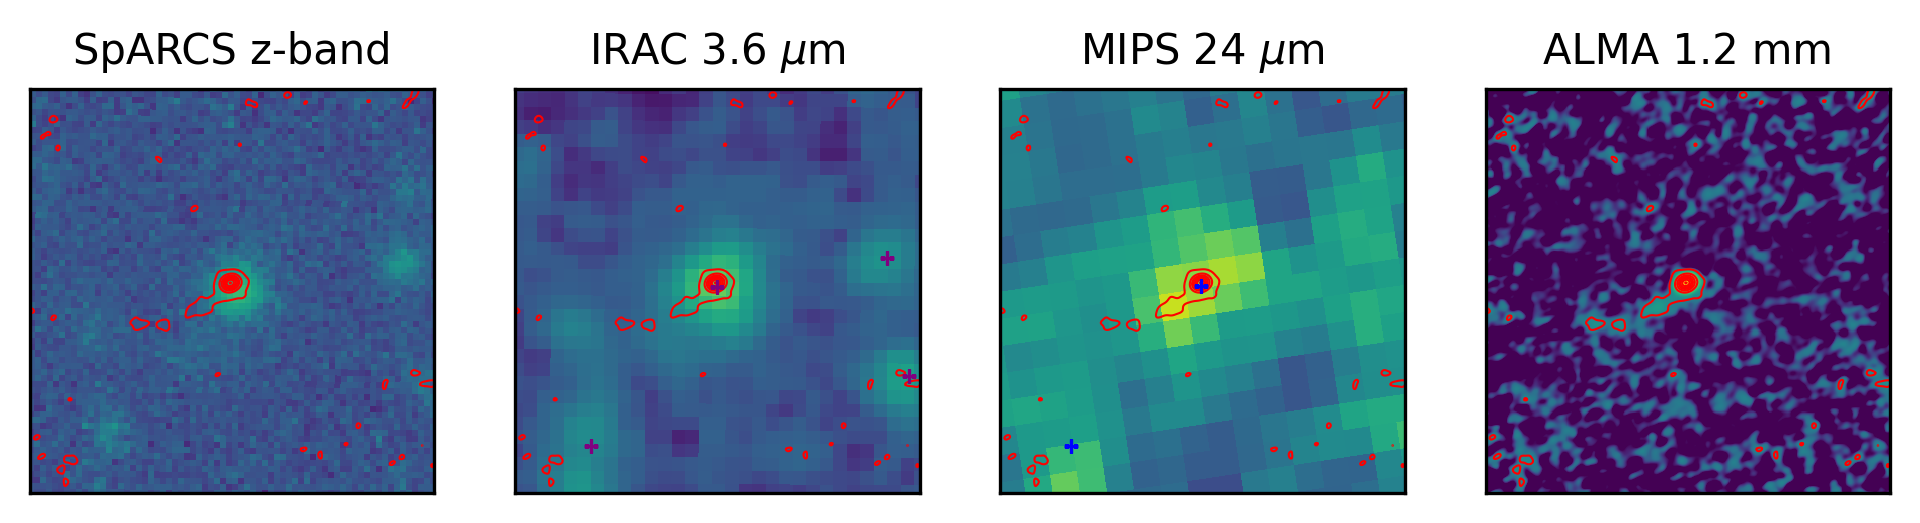

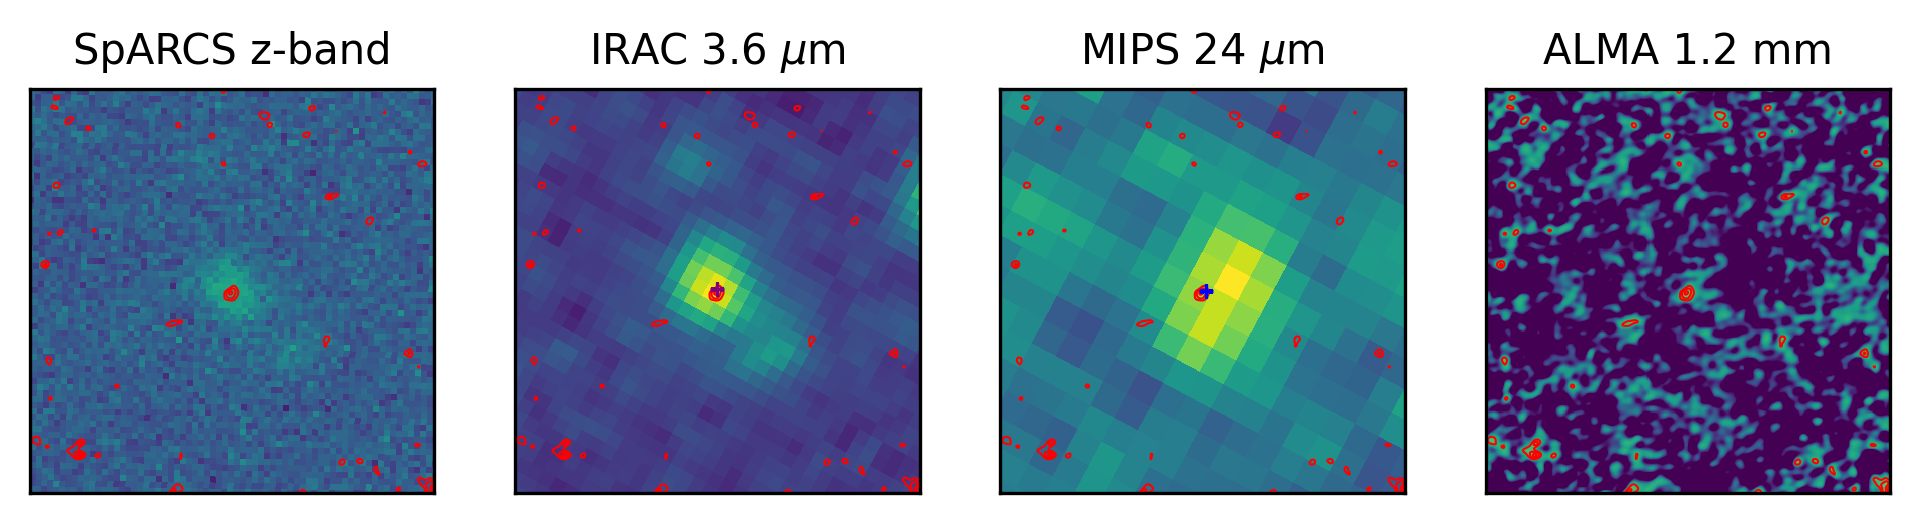

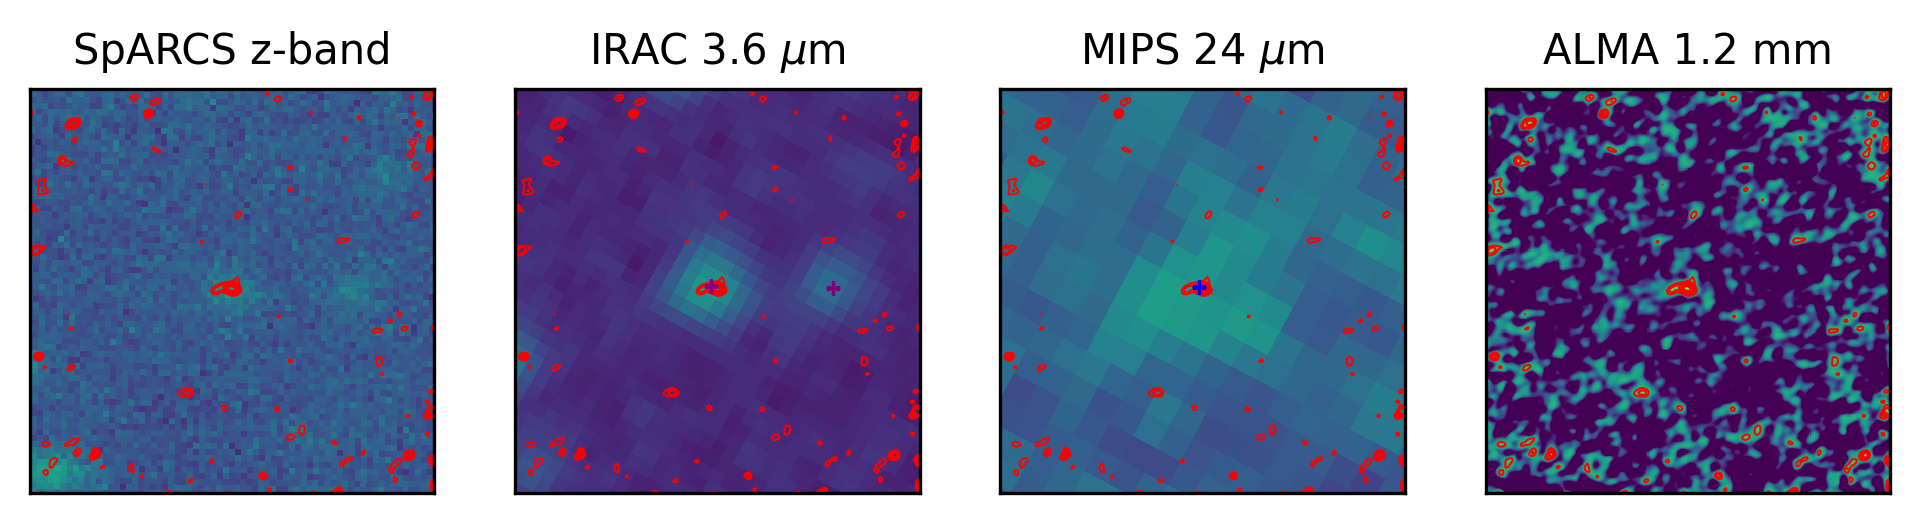

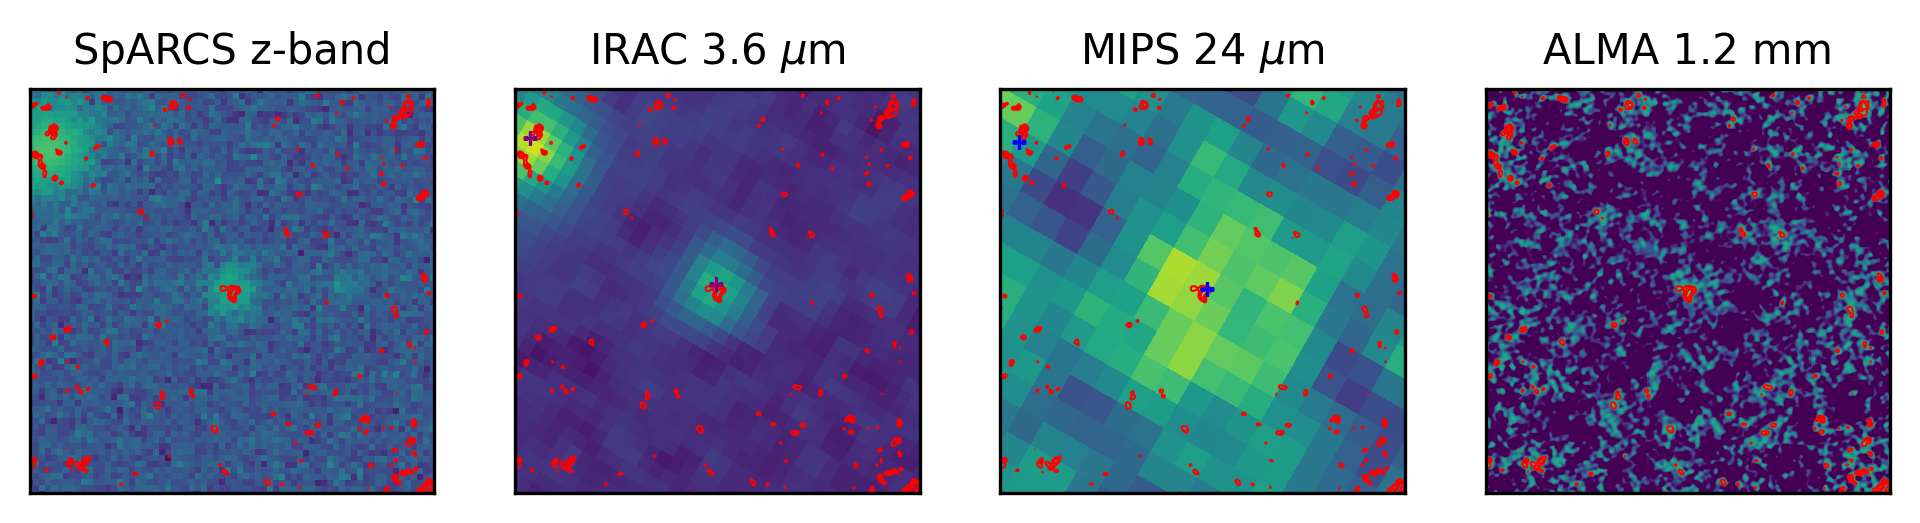

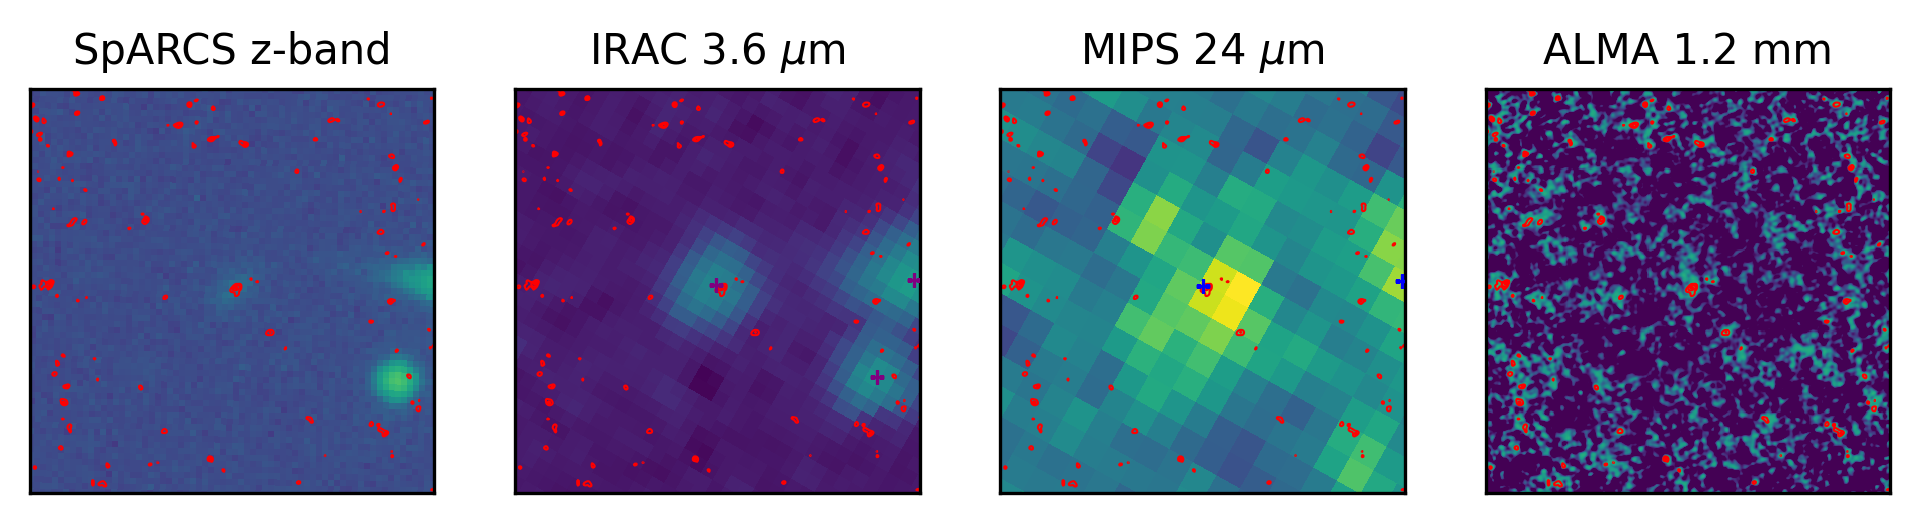

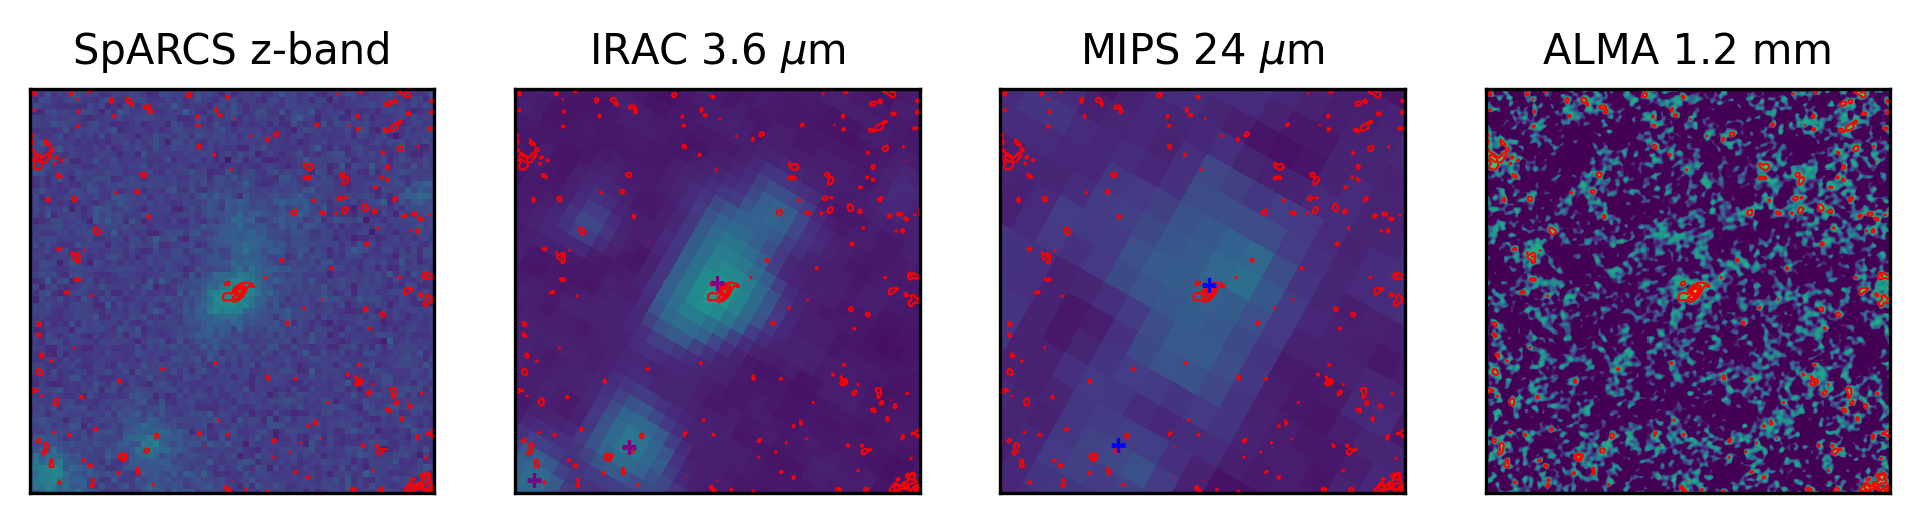

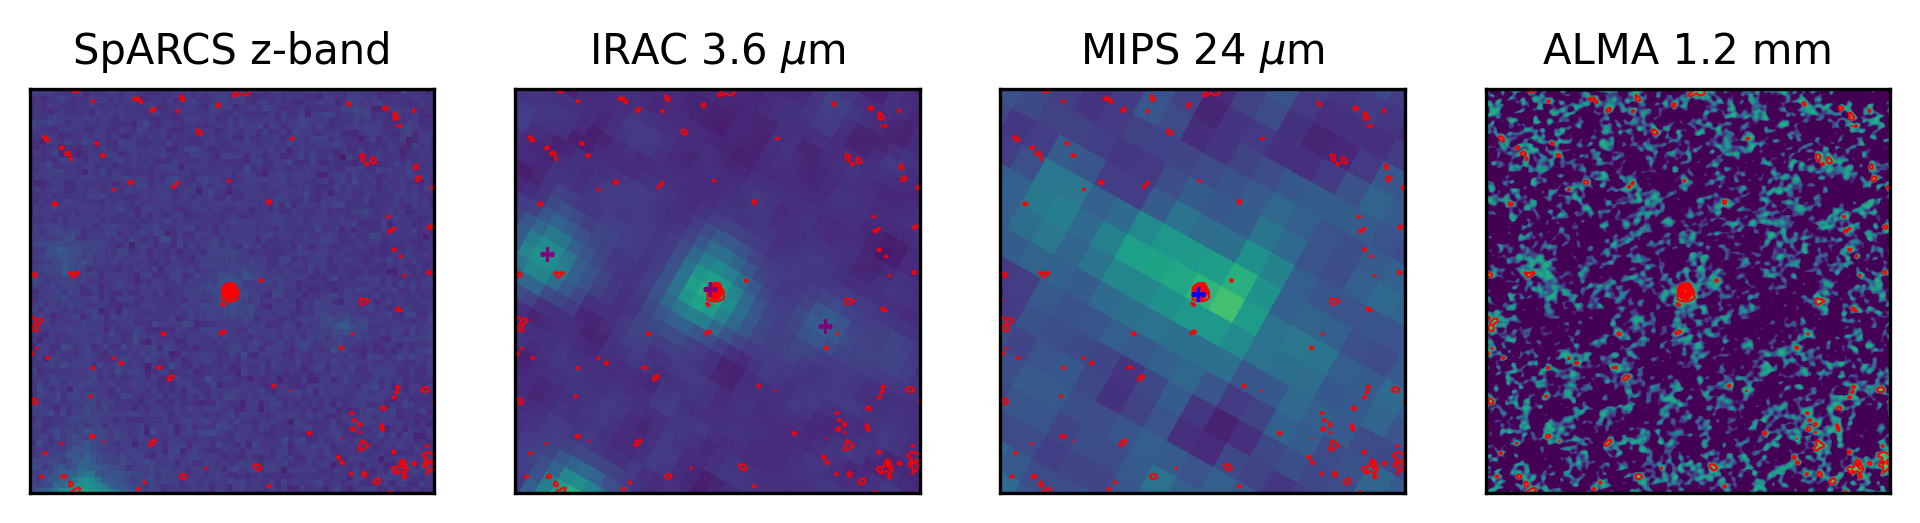

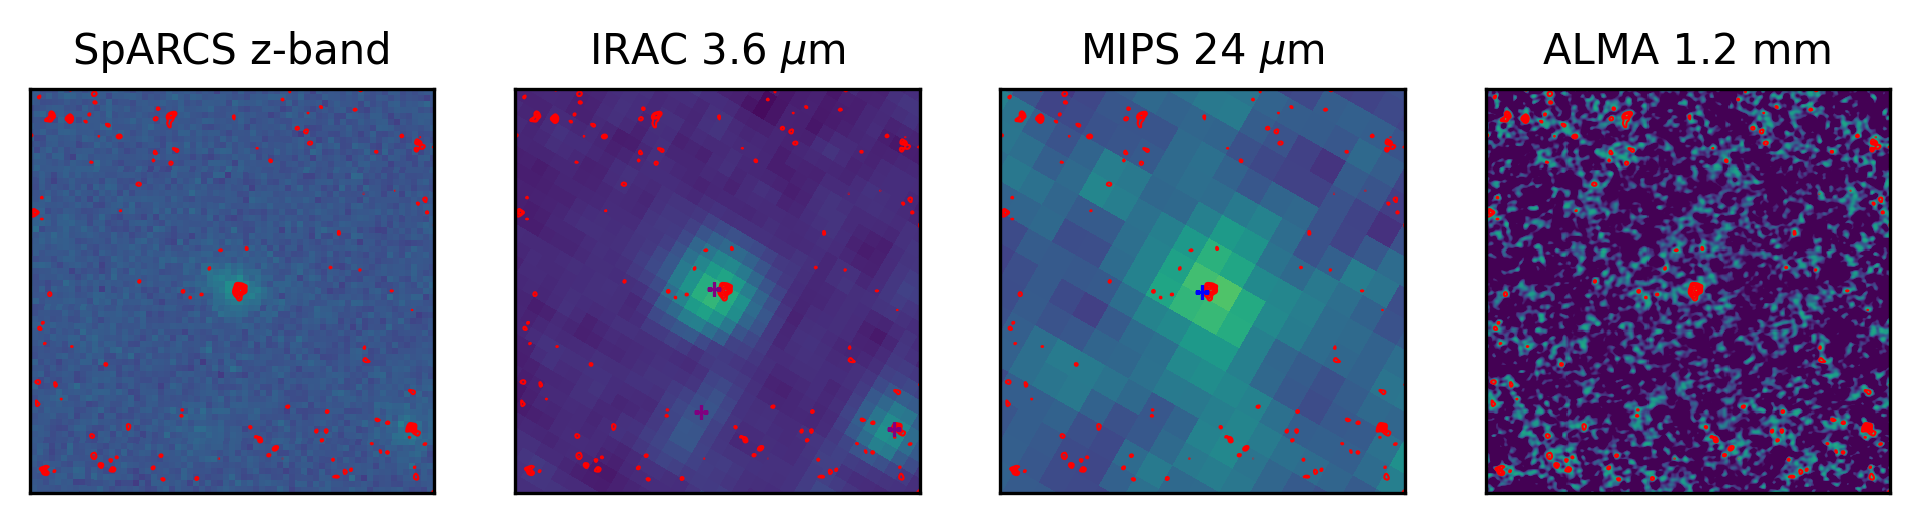

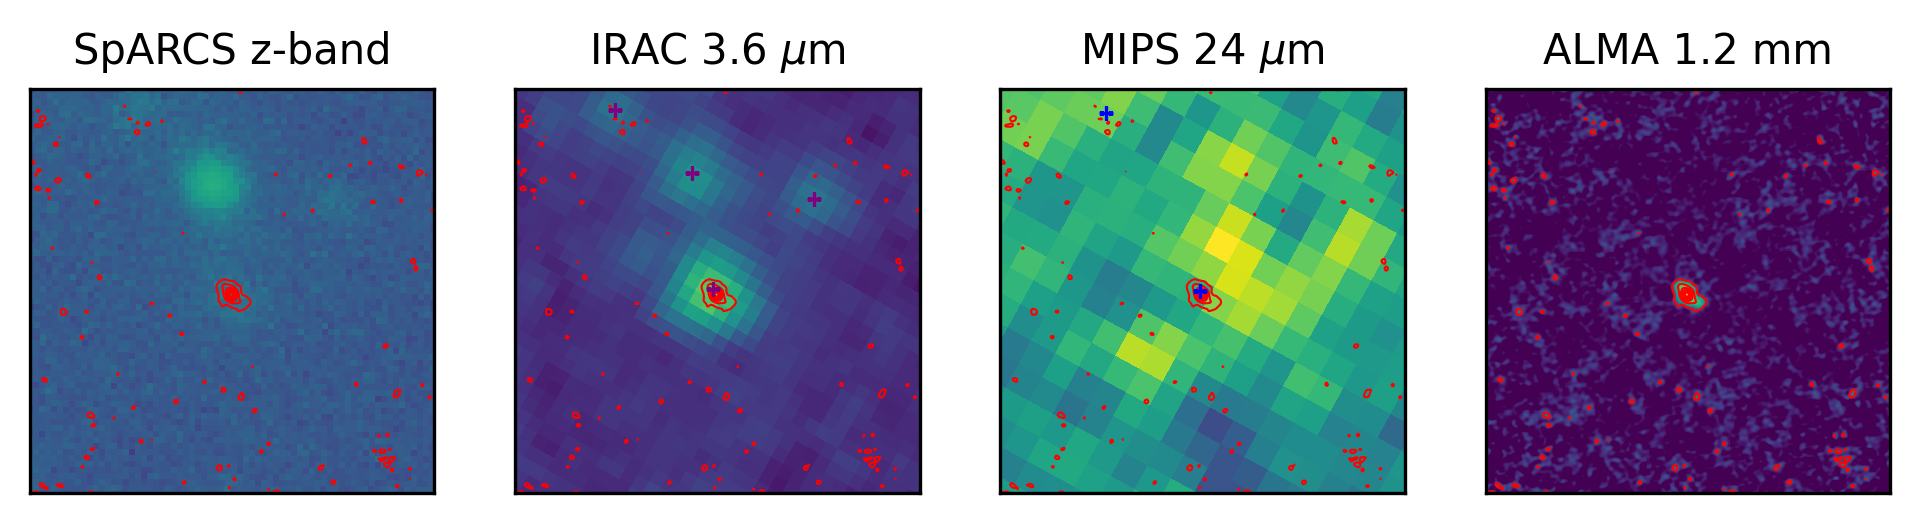

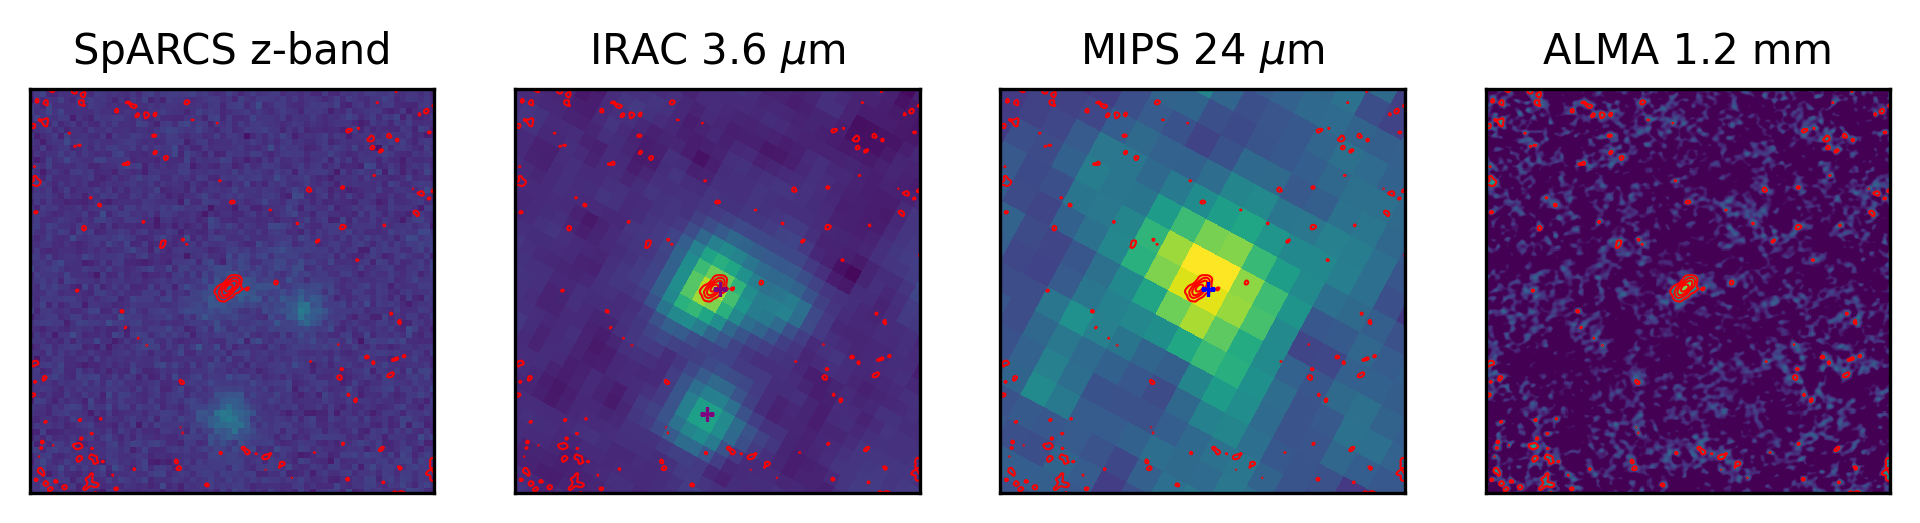

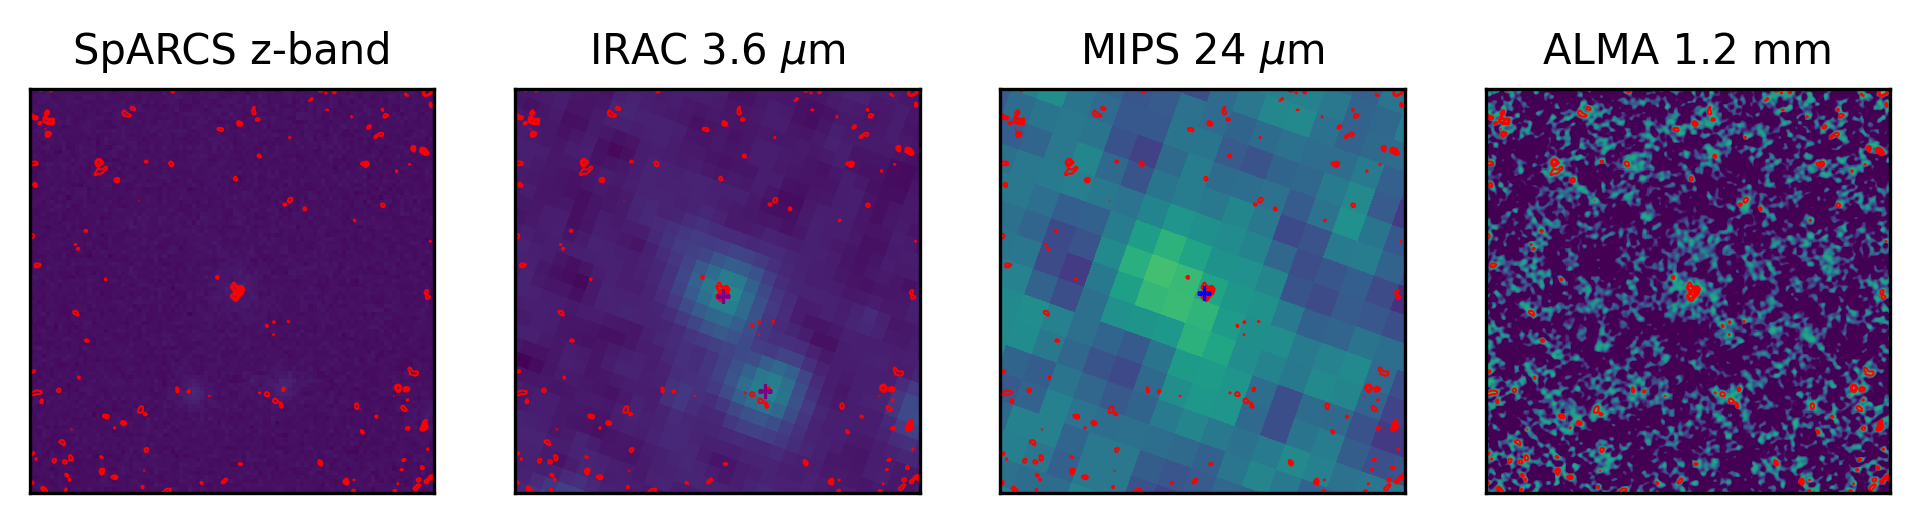

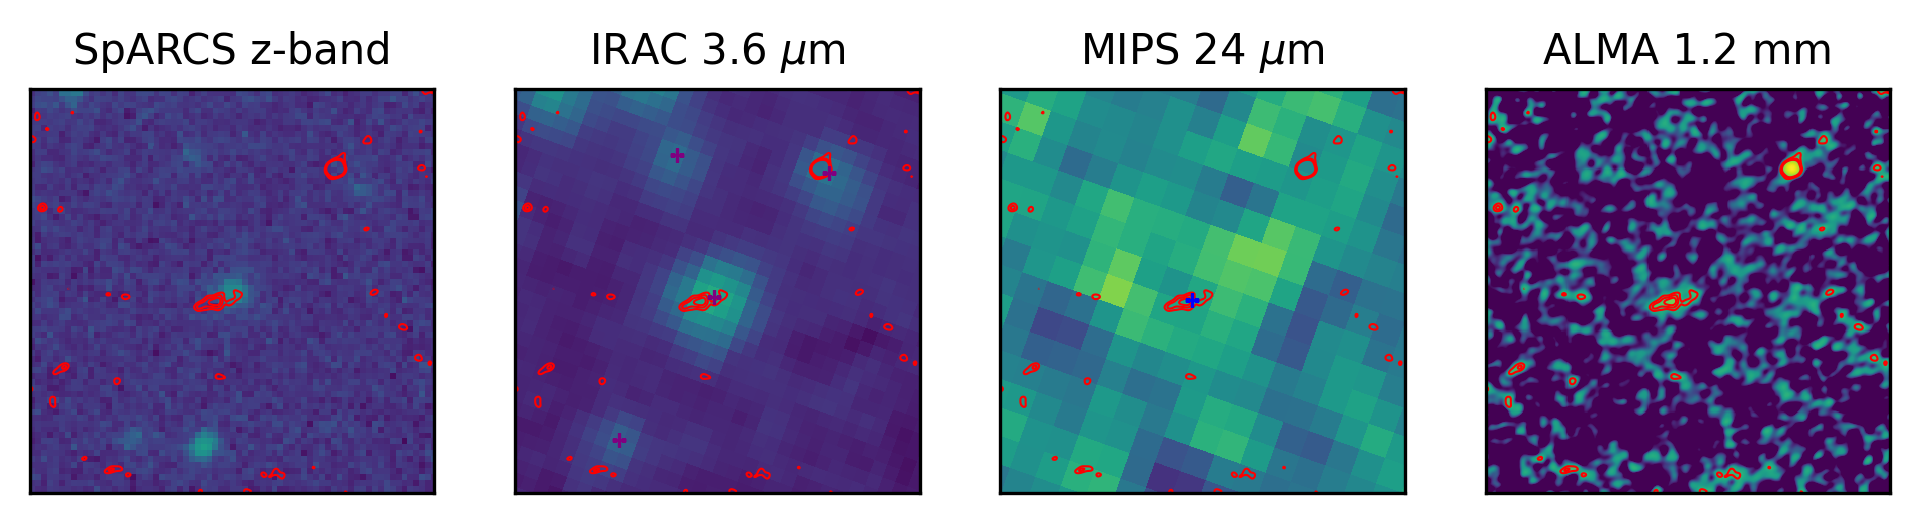

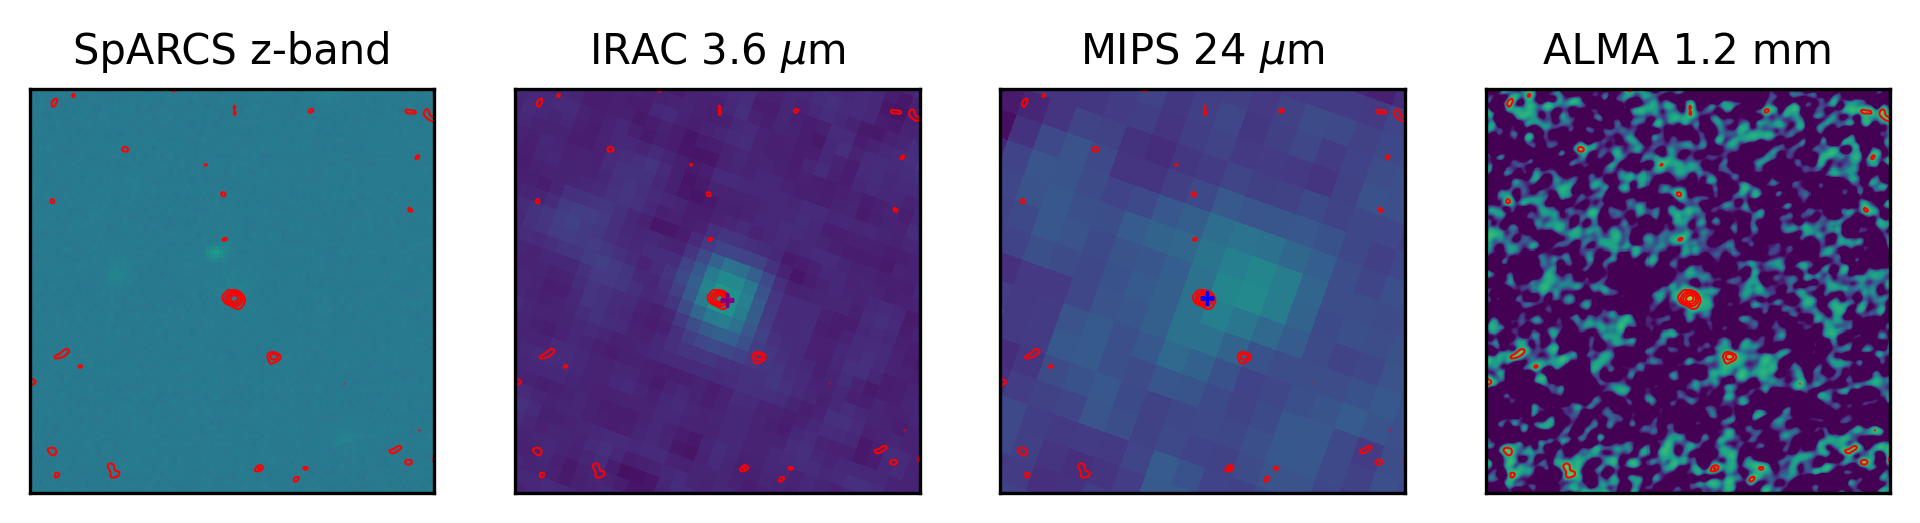

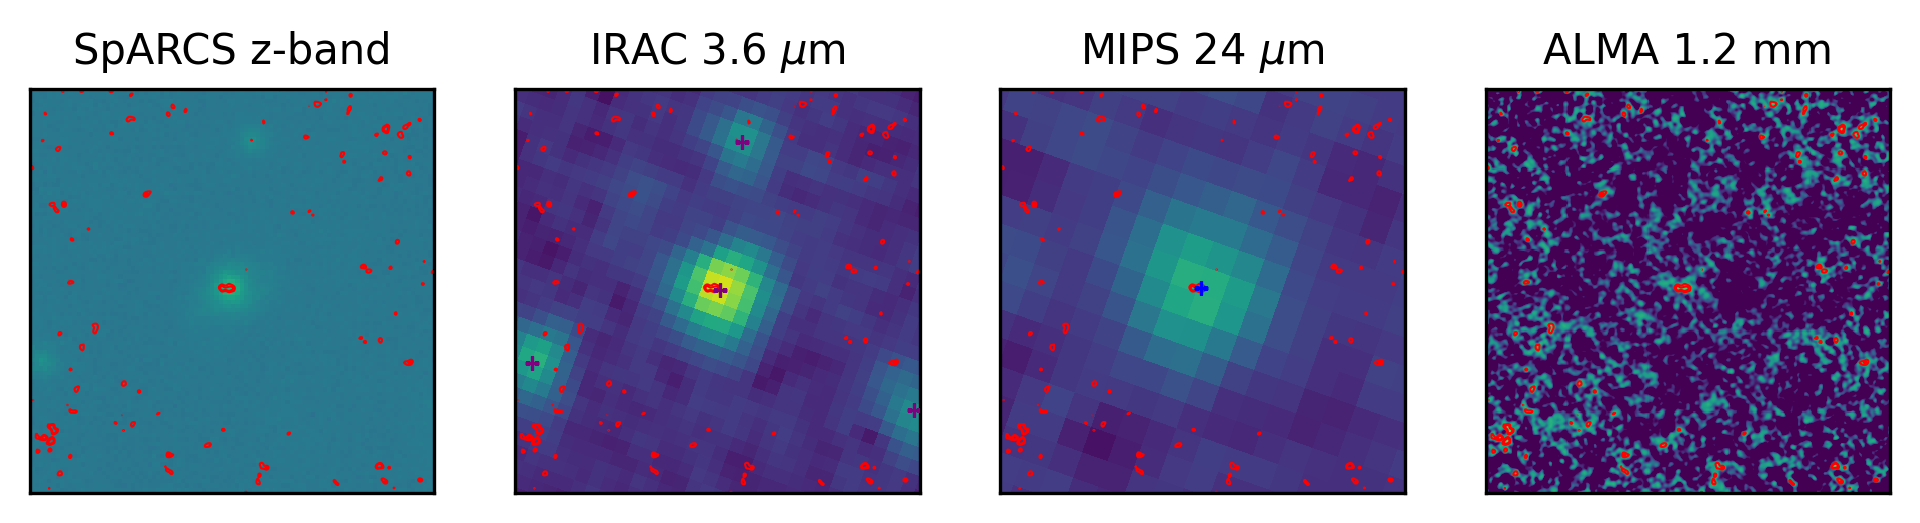

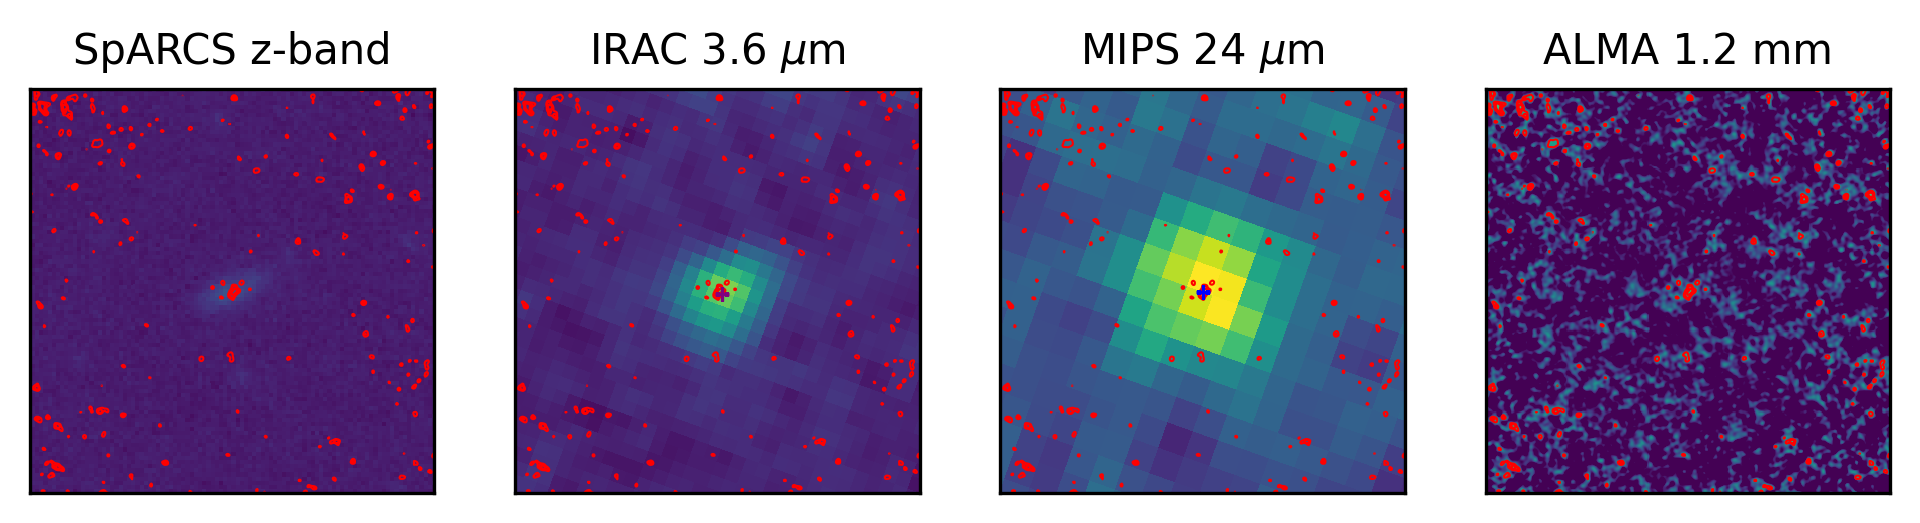

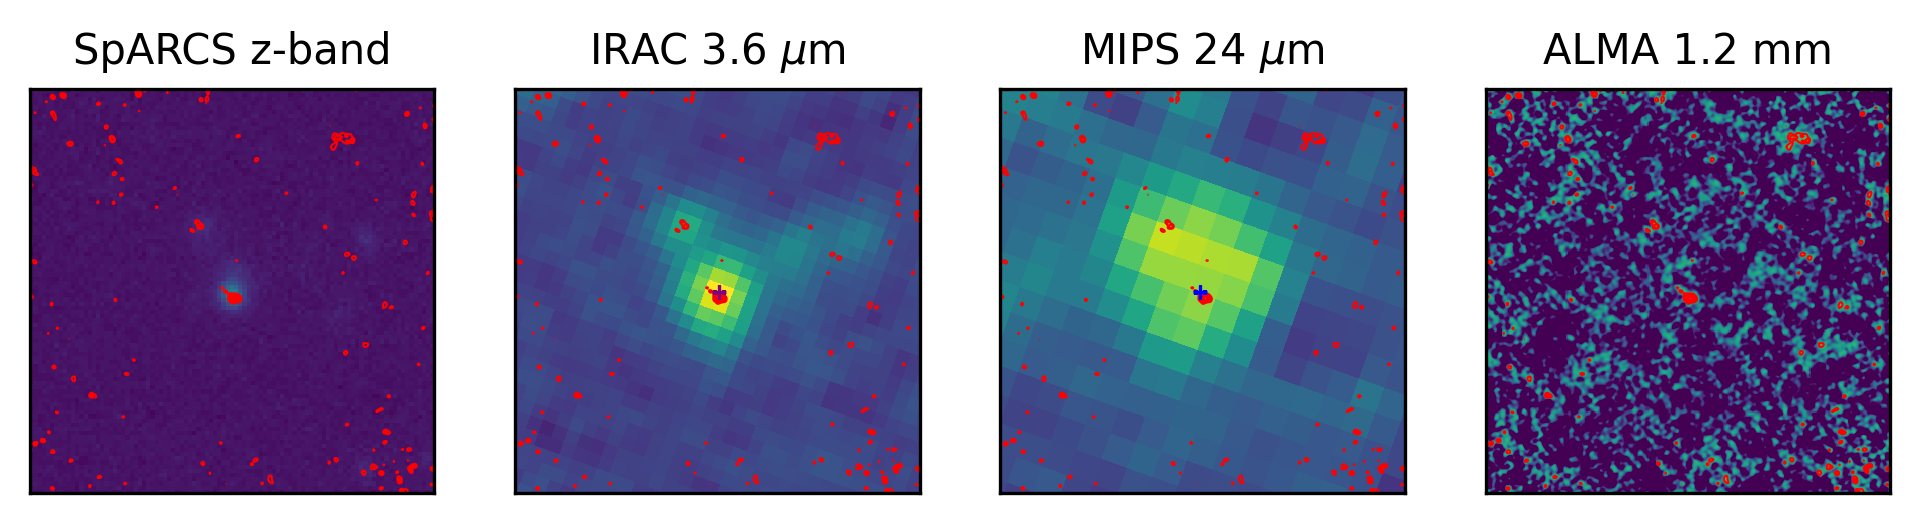

In [89]:
for bcg in bcgs:
    
    # fits images of bcg
    z_band = sparcs_path + bcg + ".fits"
    irac = irac_path + bcg +"_3.6micron.fits"
    mips = mips_path + bcg +"_24micron.fits"
    alma = alma_path + "natural/" + bcg + "_natural.fits"
    
    # reading the fits file
    header_z, data_z, wcs_z = read_fits(z_band)
    header_irac, data_irac, wcs_irac = read_fits(irac)
    header_mips, data_mips, wcs_mips = read_fits(mips)
    header_alma, data_alma, wcs_alma = read_fits(alma, 'alma')
    
    imfit_region = ast.literal_eval(df[df['BCG'] == bcg]['natural'].values[0])
    
    # irac sources
    irac_df = pd.read_csv(irac_sources_path + bcg + ".csv")
    irac_sources_coord = list(zip(irac_df.ra, irac_df.dec))
    
    ra = header_alma['CRVAL1']
    dec = header_alma['CRVAL2']
    
    c = SkyCoord(ra*u.deg, dec*u.deg)
    centerpix = wcs_alma.world_to_pixel(c)
    xlim = (centerpix[0]-200,centerpix[0]+200)
    ylim = (centerpix[1]-200,centerpix[1]+200)
    
    snr, rms = snr_rms(data_alma, centerpix, imfit_region[2]/0.045, (2+ imfit_region[2])/0.045)
    
    fig = plt.figure(dpi = 300, figsize = (8,5))
    ax1 = fig.add_subplot(141, projection=wcs_alma)
    ax2 = fig.add_subplot(142, projection=wcs_alma,sharey=ax1)
    ax3 = fig.add_subplot(143, projection=wcs_alma,sharey=ax1)
    ax4 = fig.add_subplot(144, projection=wcs_alma,sharey=ax1)
    z_trans = ax1.get_transform(wcs_z)
    irac_trans = ax2.get_transform(wcs_irac)
    mips_trans = ax3.get_transform(wcs_mips)
    
    if bcg.startswith("ES1"):
        file = "L6-ELAIS-S1-SWIRE_xID24_DR3.fits"
    elif bcg.startswith("XMM"):
        file = "L6-XMM-LSS-SWIRE_xID24_DR3.fits"
    elif bcg.startswith("CDFS"):
        file = "L5-CDFS-SWIRE_xID24_DR3.fits"
    
    _f = fits.open(hermes_path + file)
    _hermes = Table(_f[1].data).to_pandas()
    _h_catalog = SkyCoord(ra=np.array(_hermes['RA'])*u.degree, dec=np.array(_hermes['Dec'])*u.degree, frame = 'icrs')
    idx = c.separation(_h_catalog) < 20*u.arcsec
    c_matches = _h_catalog[idx]
    
    
    levels = np.arange(rms*3, snr*rms, contour_steps[bcg]*rms, dtype=None)
    
    im1 = ax1.imshow(data_z, transform = z_trans, origin = 'lower', interpolation='None',cmap = 'viridis',norm =matplotlib.colors.SymLogNorm(linthresh = 0.009))
    ax1.contour(data_alma, levels=levels, colors='red', linewidths = 0.5, zorder = 1)
    im2 = ax2.imshow(data_irac, transform = irac_trans, origin = 'lower', interpolation='None',cmap = 'viridis',norm =matplotlib.colors.SymLogNorm(linthresh = 0.01))
    ax2.contour(data_alma, levels=levels, colors='red', linewidths = 0.5, zorder = 1)
    for coord in irac_sources_coord:
        c = SkyCoord(coord[0]*u.deg, coord[1]*u.deg, frame = 'fk5')
        c_pix = wcs_irac.world_to_pixel(c)
        ax2.scatter(c_pix[0], c_pix[1], marker = '+', color = 'purple', zorder = 5, transform = irac_trans, s = 10, lw= 0.8, label = 'irac sources')
#     beam_irac.plot(ax=ax2, facecolor='none', edgecolor='white', lw=1, alpha = 1, label = 'MRS')
    im3 = ax3.imshow(data_mips, transform = mips_trans, origin = 'lower', interpolation='None',cmap = 'viridis',norm =matplotlib.colors.SymLogNorm(linthresh = 1))
    ax3.contour(data_alma, levels=levels, colors='red', linewidths = 0.5, zorder = 1)
    
    for coord in c_matches:
        c_pix = wcs_mips.world_to_pixel(coord)
        ax3.scatter(c_pix[0], c_pix[1], marker = '+', color = 'blue', zorder = 5, transform = mips_trans, s = 10, lw= 0.8, label = 'mips sources')
    ax4.contour(data_alma, levels=levels, colors = 'red', linewidths = 0.5, zorder = 1, alpha = 1)
    data_alma[data_alma<0] = 0
    
    if bcg == 'CDFS-18':
        linthresh = 0.01
    else:
        linthresh = 0.1
    im4 = ax4.imshow(data_alma, origin = 'lower', interpolation='None',cmap = 'viridis',norm =matplotlib.colors.SymLogNorm(linthresh = linthresh))
    

    ax1.coords[1].set_ticks_visible(False)
    ax1.coords[1].set_ticklabel_visible(False)
    ax2.coords[1].set_ticks_visible(False)
    ax2.coords[1].set_ticklabel_visible(False)
    ax3.coords[1].set_ticks_visible(False)
    ax3.coords[1].set_ticklabel_visible(False)
    ax4.coords[1].set_ticks_visible(False)
    ax4.coords[1].set_ticklabel_visible(False)
    ax1.coords[0].set_ticks_visible(False)
    ax1.coords[0].set_ticklabel_visible(False)
    ax2.coords[0].set_ticks_visible(False)
    ax2.coords[0].set_ticklabel_visible(False)
    ax3.coords[0].set_ticks_visible(False)
    ax3.coords[0].set_ticklabel_visible(False)
    ax4.coords[0].set_ticks_visible(False)
    ax4.coords[0].set_ticklabel_visible(False)
    
    ax1.set_xlim(xlim)
    ax1.set_ylim(ylim)
    ax2.set_xlim(xlim)
    ax2.set_ylim(ylim)
    ax3.set_xlim(xlim)
    ax3.set_ylim(ylim)
    ax4.set_xlim(xlim)
    ax4.set_ylim(ylim)
    ax1.set_title("SpARCS z-band", size = 10)
    ax2.set_title("IRAC 3.6 $\mu$m", size = 10)
    ax3.set_title("MIPS 24 $\mu$m", size = 10)
    ax4.set_title("ALMA 1.2 mm", size = 10)
    
    fig.savefig("/Users/arames52/Desktop/CASA Imaging/Plots/" + bcg + "_mw_stamps.jpg", dpi = 300)

In [10]:
from photutils.aperture import CircularAperture, ApertureStats

ImportError: cannot import name 'ApertureStats' from 'photutils.aperture' (/Users/arames52/opt/anaconda3/envs/anjali/lib/python3.8/site-packages/photutils/aperture/__init__.py)

In [ ]:
core.PixelAperture